# PROJET 6 : CLASSIFIEZ AUTOMATIQUEMENT DES BIENS DE CONSOMMATION :

# PARTIE 1 - DONNÉES TEXTUELLES

## 0 - PRÉALABLES :

### A - Importation des librairies :

In [3]:
# basics :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from os import listdir
import time
import pickle
import logging
logging.disable(logging.WARNING)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# natural language processing :
import nltk
import nlp_tools as nlp
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# dimension reduction & high dimensions visualisations :
from sklearn import manifold, decomposition

# clustering :
from sklearn import cluster, metrics

# encoding :
from sklearn import preprocessing

# image reading & graphics :
from matplotlib.image import imread
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objects as go
import cv2

# Tensorflow :
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

# Bert
import os
import transformers

# Image Transfer learning :
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

os.environ["TF_KERAS"]='1'

### B - Importation des fichiers :

In [6]:
# Importation des fichiers :
path = "C:/Users/7700k/Desktop/Openclassrooms/Classifiez_automatiquement_des_biens_de_consommation/dataset"
data = pd.read_csv(path + "/" + "flipkart.csv")

### C - Suppression des variables inutiles :

In [7]:
# Suppression des variables inutiles
data = data[["uniq_id","product_name","product_category_tree","description","brand"]]

## I - PRÉPARATION ET PREPROCESSING :

### A - Extraction des catégories de la variable "product_category_tree" :

#### 1) Typographie de la variable "product_category_tree" :

In [8]:
# Affichage d'une ligne de la variable :
data["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

#### 2) Extraction de la catégorie 1 :

In [9]:
# Création de la catégorie 1 :
data["category_1"] = data["product_category_tree"].str.split(" >>").str[0]
data["category_1"] = data["category_1"].str.replace("^\[.|.\]$","")

In [10]:
# Nombre de valeurs pour la catégorie 1 :
data["category_1"].nunique()

7

#### 3) Extraction de la catégorie 2 :

In [11]:
# Création de la catégorie 2 :
data["category_2"] = data["product_category_tree"].str.split(" >>").str[1]

In [12]:
# Nombre de valeurs pour la catégorie 2 :
data["category_2"].nunique()

63

#### 4) Nombre d'individus par catégories :

In [13]:
# Comptage du nombre de produit par catégorie 1 :
data[["uniq_id","category_1"]].groupby("category_1").count()

uniq_id
category_1                         
Baby Care                       150
Beauty and Personal Care        150
Computers                       150
Home Decor & Festive Needs      150
Home Furnishing                 150
Kitchen & Dining                150
Watches                         150

#### 5) Conclusion :

Dans le cadre de notre mission qui consiste, pour l'instant à vérifier la faisabilité d'une classification automatique, nous utiliserons la catégorie mère (category_1) qui ne contient que 7 catégories de produits et dont les  le nombre d'individus est parfaitement équilibré.

#### 6) Encodage des catégories :

In [14]:
# Encodage :
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["category_1"])

### B - Préparation des données textuelles :

#### 1) Normalisation et lemmatisation:

In [15]:
# Application des fonctions de traitement :
data["description_prepro"] = data["description"].apply(lambda x : nlp.transform_bow_lem_fct(x))

#### 2) Suppression des mots non-liés aux produits (superlatifs, livraison, promotions...):

In [16]:
# Mots les plus fréquents :
Counter(" ".join(data["description_prepro"]).split()).most_common(5)

[('product', 863), ('only', 718), ('free', 617), ('for', 611), ('buy', 581)]

In [17]:
# Mots à effacer :
other_stop_words =["product","free","for","buy","delivery","shipping","cash","price","day",
                   "flipkart.com","guarantee","online","specification","the","type","sale",
                   "number","warranty","quality","brand","best","model","key","great","made",
                   "perfect","gift","this","ideal","with","discount","these","feature","only",
                   "and","one","also","genuine"]

In [18]:
# Effacement :
data["description_prepro"].replace(other_stop_words,"",regex=True, inplace=True)

#### 3) Suppression des chiffres, nombres et ponctuation : 

In [19]:
# Suppression des nombres et des chiffres :
data["description_prepro"].replace('\d+', '', regex=True, inplace=True)

#### 4) Récupération des longueurs de phrases :

In [20]:
# Min & max length
length = data["description"].apply(lambda x : len(nltk.word_tokenize(x)))
length_prepro = data["description_prepro"].apply(lambda x : len(nltk.word_tokenize(x)))
print("min length : ", length.min())
print("max length : ", length.max())
print("min length prepro : ", length_prepro.min())
print("max length prepro : ", length_prepro.max())

min length :  16
max length :  639
min length prepro :  2
max length prepro :  327


## II - COUNTVECTORIZER :

### A - Bag of Words (CountVectorizer) :

In [17]:
# Bag of words :
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
cv_fit = cvect.fit(data["description_prepro"])
cv_transform = cvect.transform(data["description_prepro"])

### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [18]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(cv_transform)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

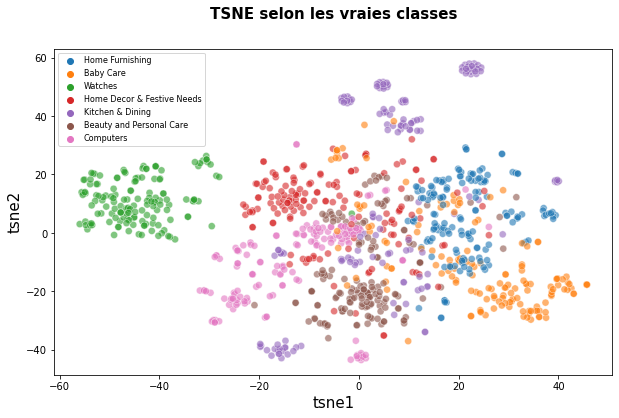

In [19]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters

#### 1) Création de clusters à partir du T-SNE :

In [20]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

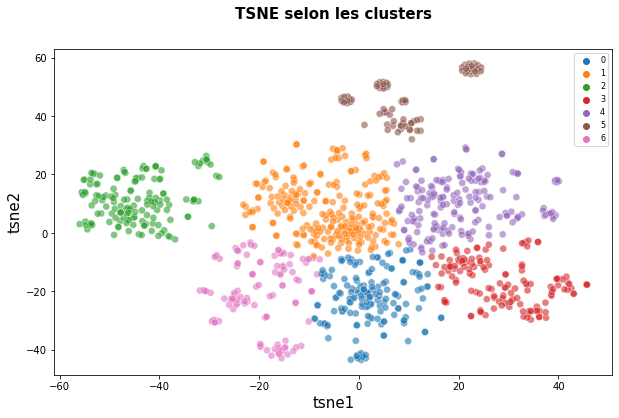

ARI :  0.4384390854386619


In [21]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.39897316057803445

#### 3) Analyse par classes :

In [22]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    161
1    235
2    149
3    138
4    178
5     77
6    112
Name: class, dtype: int64

In [23]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [24]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[102   8   0  19  19   2   0]
 [  2  96   8  34  10   0   0]
 [  0  15  69  64   2   0   0]
 [  1  11   8 108  21   1   0]
 [ 33   3   0   0 114   0   0]
 [  0  28  27   9  12  74   0]
 [  0   0   0   1   0   0 149]]

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       150
           1       0.60      0.64      0.62       150
           2       0.62      0.46      0.53       150
           3       0.46      0.72      0.56       150
           4       0.64      0.76      0.70       150
           5       0.96      0.49      0.65       150
           6       1.00      0.99      1.00       150

    accuracy                           0.68      1050
   macro avg       0.72      0.68      0.68      1050
weighted avg       0.72      0.68      0.68      1050



<AxesSubplot:>

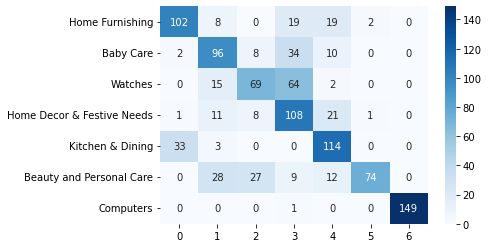

In [25]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [26]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [27]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## III - TF-IDF :

### A - Bag of words (Tf-idf) :

In [28]:
# Bag of words :
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf_fit = ctf.fit(data["description"]) 
ctf_transform = ctf.transform(data["description"])

### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [29]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(ctf_transform)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

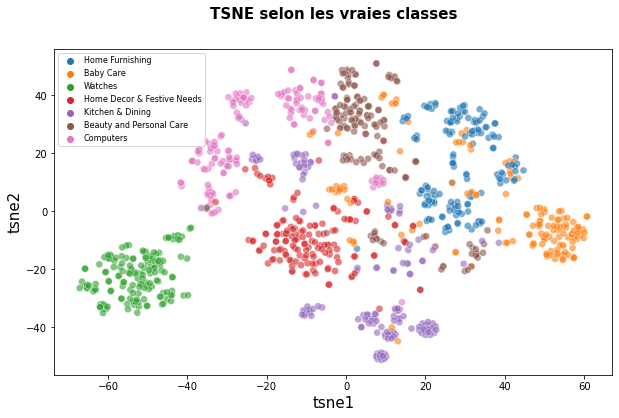

In [30]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [31]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

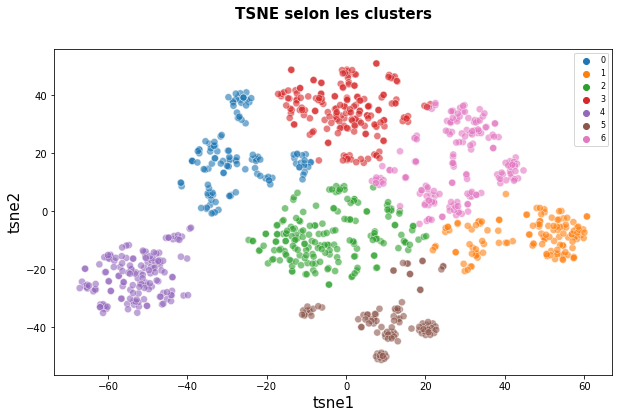

ARI :  0.5567402825666966


In [32]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI avec preprocessing du corpus est 0.4817630825678669

#### 3) Analyse par classes :

In [33]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    126
1    129
2    185
3    183
4    150
5    104
6    173
Name: class, dtype: int64

In [34]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [35]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[ 96  12   0  17  23   2   0]
 [ 14 108   2  12  10   4   0]
 [  0  52  85   1  11   1   0]
 [  0   2  11 135   0   2   0]
 [ 14   7   0   1 128   0   0]
 [  5   2  28  19   1  95   0]
 [  0   0   0   0   0   0 150]]

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       150
           1       0.59      0.72      0.65       150
           2       0.67      0.57      0.62       150
           3       0.73      0.90      0.81       150
           4       0.74      0.85      0.79       150
           5       0.91      0.63      0.75       150
           6       1.00      1.00      1.00       150

    accuracy                           0.76      1050
   macro avg       0.77      0.76      0.76      1050
weighted avg       0.77      0.76      0.76      1050



<AxesSubplot:>

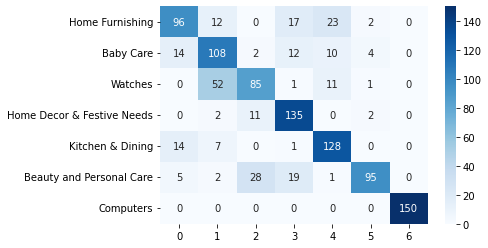

In [36]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [37]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [38]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## IV - LATENT DIRICHLET ALLOCATION (LDA) :

### A - Création du modèle LDA :

#### 1) Préparation des données :

In [39]:
# Fonction de tokenisation :
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [40]:
# tokenisation :
data_words = list(sent_to_words(data["description_prepro"]))

In [41]:
# Conversion en corpus et dictionnaire :
id2word = gensim.corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

#### 2) Création et entraînement du modèle LDA :

In [42]:
# Définition du modèle LDA :
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#### 3) Mots clé des 7 sujets :

In [43]:
# Mots clé des 7 sujets définis :
print(lda_model.print_topics())

[(0, '0.066*"use" + 0.046*"mug" + 0.032*"ceramic" + 0.026*"piece" + 0.024*"designed" + 0.021*"safe" + 0.016*"size" + 0.013*"using" + 0.013*"note" + 0.010*"capacity"'), (1, '0.136*"skin" + 0.045*"combo" + 0.031*"aroma" + 0.029*"double" + 0.027*"all" + 0.017*"out" + 0.016*"soap" + 0.016*"bowl" + 0.016*"like" + 0.015*"you"'), (2, '0.063*"shape" + 0.048*"sticker" + 0.041*"wall" + 0.029*"apply" + 0.029*"vinyl" + 0.023*"showpiece" + 0.018*"decal" + 0.017*"remove" + 0.017*"paper" + 0.015*"green"'), (3, '0.116*"replacement" + 0.100*"rs" + 0.037*"men" + 0.035*"dark" + 0.035*"watch" + 0.027*"india" + 0.023*"analog" + 0.014*"spray" + 0.010*"pigmented" + 0.009*"orange"'), (4, '0.037*"pack" + 0.031*"inch" + 0.028*"color" + 0.026*"print" + 0.023*"box" + 0.022*"multicolor" + 0.021*"package" + 0.021*"set" + 0.019*"general" + 0.018*"design"'), (5, '0.036*"easy" + 0.034*"cotton" + 0.034*"baby" + 0.026*"fabric" + 0.026*"detail" + 0.026*"shirt" + 0.025*"boy" + 0.024*"comt" + 0.020*"fit" + 0.019*"sleeve"')

#### 4) Récupération des poids :

In [44]:
# Récupération des poids :
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

topic_weights_arr = pd.DataFrame(topic_weights).fillna(0)

### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [45]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(topic_weights_arr)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

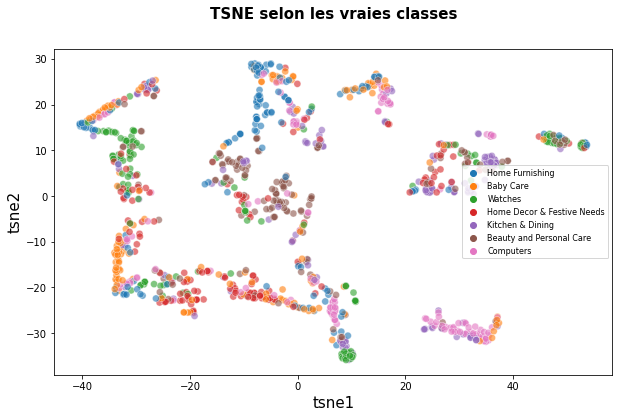

In [46]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [47]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

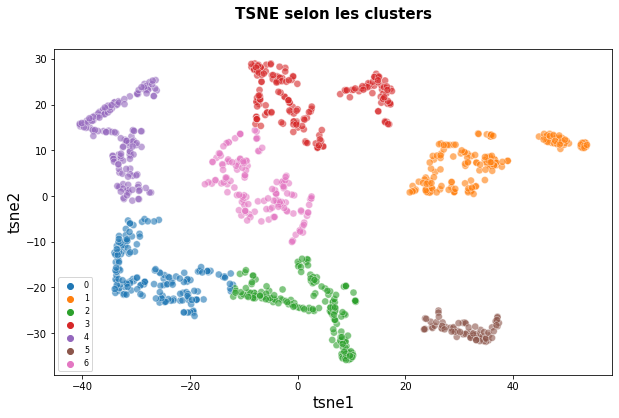

ARI :  0.10530453103987378


In [48]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.03668071531025748

### 3) Analyse par classes :

In [49]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    165
1    171
2    165
3    179
4    153
5     73
6    144
Name: class, dtype: int64

In [50]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [51]:
# Choix manuel pour l'ordre de la matrice :
np.argmax(conf_mat, axis=0)

array([3, 5, 3, 4, 6, 2, 1], dtype=int64)

In [52]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [0, 5, 3, 4, 6, 2, 1]
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[47  4  7 26 39  3 24]
 [ 8 82  3 17  5 26  9]
 [17  6 45 29 35  9  9]
 [49 14  0 33 10 24 20]
 [17 14  0 18 69 12 20]
 [ 9 13 18 16 18 59 17]
 [18 11  0 26  3 38 54]]

              precision    recall  f1-score   support

           0       0.28      0.31      0.30       150
           1       0.57      0.55      0.56       150
           2       0.62      0.30      0.40       150
           3       0.20      0.22      0.21       150
           4       0.39      0.46      0.42       150
           5       0.35      0.39      0.37       150
           6       0.35      0.36      0.36       150

    accuracy                           0.37      1050
   macro avg       0.39      0.37      0.37      1050
weighted avg       0.39      0.37      0.37      1050



<AxesSubplot:>

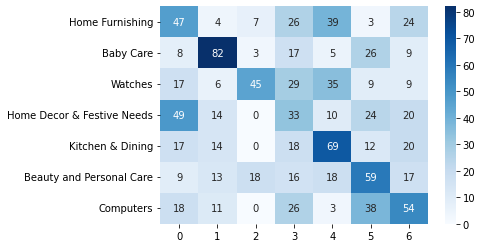

In [53]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [54]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [55]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## V - WORD2VEC :

### A - Création du modèle Word2Vec :

#### 1) Définitions :

In [56]:
# Définitions :
w2v_size=100
w2v_window=5
w2v_min_count=length_prepro.min()
w2v_epochs=100
maxlen = length_prepro.max()
descriptions = data["description_prepro"].to_list()
descriptions = [gensim.utils.simple_preprocess(text) for text in descriptions]

#### 2) Création et entraînement du modèle Word2Vec :

In [57]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

w2v_model.build_vocab(descriptions)
w2v_model.train(descriptions, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3277
Word2Vec trained


In [58]:
# Tokenization :
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)
x_descriptions = pad_sequences(tokenizer.texts_to_sequences(descriptions),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4642


### B - Embedding :

#### 1) Matrice d'embedding :

In [59]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.7061
Embedding matrix: (4642, 100)


#### 2) Modèle d'embedding :

In [60]:
# Création du modèle d'embedding
input=Input(shape=(len(x_descriptions),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 327)]             0         
                                                                 
 embedding (Embedding)       (None, 327, 100)          464200    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 464,200
Trainable params: 464,200
Non-trainable params: 0
_________________________________________________________________


#### 3) Récupération des prédictions du modèle :

In [61]:
# Récupération des prédictions du modèle :
embeddings = embed_model.predict(x_descriptions)

33/33 [==============================] - 0s 2ms/step


### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [62]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(embeddings)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

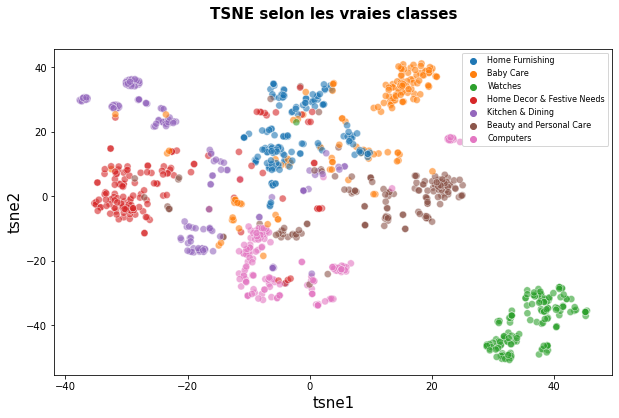

In [63]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [64]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

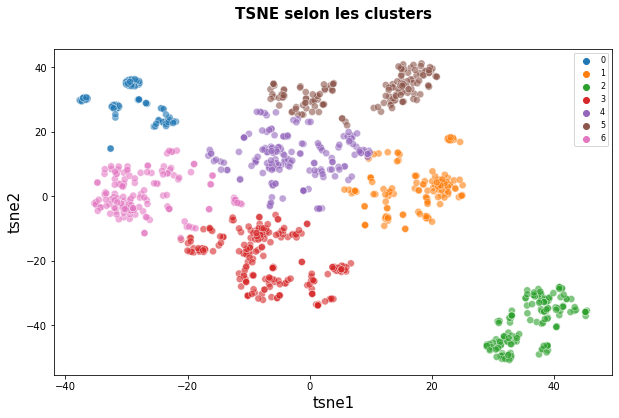

ARI :  0.5310275451308266


In [65]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.28682440127951436

#### 3) Analyse par classes :

In [66]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0     79
1    135
2    149
3    213
4    179
5    147
6    148
Name: class, dtype: int64

In [67]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [68]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[ 92  12  11  11  22   2   0]
 [  3 111  22   8   6   0   0]
 [  0  12 136   0   2   0   0]
 [  3   0   5 118  21   3   0]
 [ 49   0   0   0 101   0   0]
 [  0   0  39  11  26  74   0]
 [  0   0   0   0   1   0 149]]

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       150
           1       0.82      0.74      0.78       150
           2       0.64      0.91      0.75       150
           3       0.80      0.79      0.79       150
           4       0.56      0.67      0.61       150
           5       0.94      0.49      0.65       150
           6       1.00      0.99      1.00       150

    accuracy                           0.74      1050
   macro avg       0.77      0.74      0.74      1050
weighted avg       0.77      0.74      0.74      1050



<AxesSubplot:>

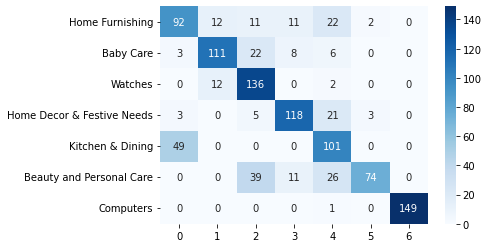

In [69]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [70]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [71]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## VI - BERT (HUNGER FACE) :

#### 0) version & cuda :

In [72]:
# Version & cuda :
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


### A - Création du modèle Bert Hunger Face :

#### 1) Création du modèle :

In [151]:
# Paramètres du modèle :
max_length = length_prepro.max()
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
descriptions = data["description_prepro"].to_list()

#### 2) Entraînement du modèle :

In [152]:
# Entraînement du modèle :
tf.autograph.experimental.do_not_convert
features_bert, last_hidden_states_tot = nlp.feature_BERT_fct(model, model_type, descriptions, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 3s 3s/step
temps traitement :  306.0


### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [153]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(features_bert)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

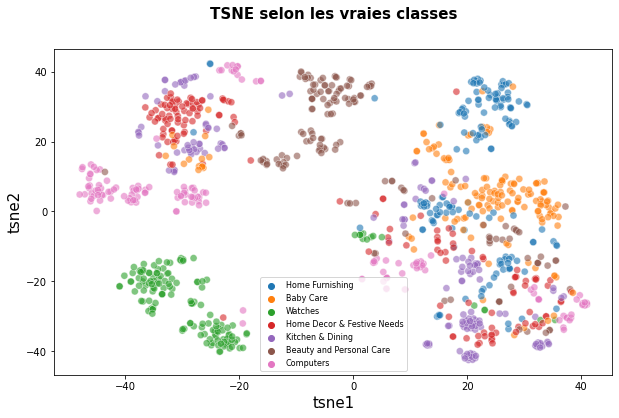

In [154]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters

#### 1) Création de clusters à partir du T-SNE :

In [155]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

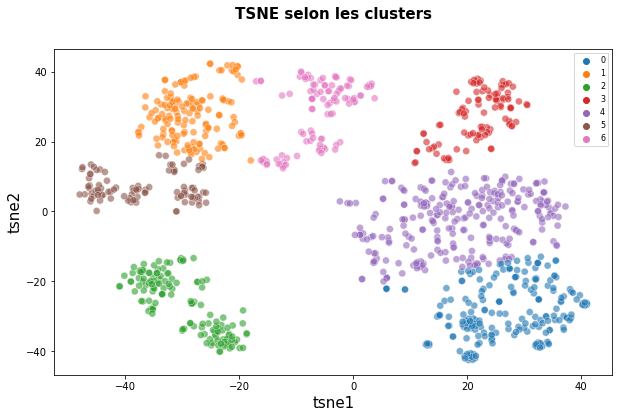

ARI :  0.3127100821176885


In [156]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.30559121575559095

#### 3) Analyse par classes :

In [157]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    203
1    145
2    138
3    100
4    267
5     95
6    102
Name: class, dtype: int64

In [158]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [159]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[100   0   8   6  25  11   0]
 [ 28  96   1   5   0  20   0]
 [ 27   3  78  12   0  28   2]
 [ 25   0   4  74   1  45   1]
 [ 50   1   0   3  72  24   0]
 [ 27   2   4  45   2  70   0]
 [ 10   0   0   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.37      0.67      0.48       150
           1       0.94      0.64      0.76       150
           2       0.82      0.52      0.64       150
           3       0.51      0.49      0.50       150
           4       0.72      0.48      0.58       150
           5       0.34      0.47      0.40       150
           6       0.98      0.90      0.94       150

    accuracy                           0.60      1050
   macro avg       0.67      0.60      0.61      1050
weighted avg       0.67      0.60      0.61      1050



<AxesSubplot:>

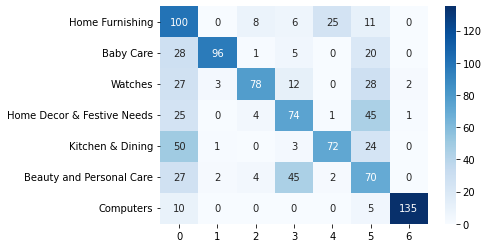

In [160]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [161]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [162]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## VII - Bert Hub Tensorflow :

### A - Création du modèle Bert Hub Tensorflow :

#### 1) Récupération du modèle :

In [79]:
# Récupération du modèle :
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

#### 2) Entraînement du modèle :

In [80]:
# Paramètres et entraînement du modèle :
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = nlp.feature_BERT_fct(model, model_type, descriptions,
                                                             max_length, batch_size, mode='TFhub')

temps traitement :  61.0


### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [81]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(features_bert)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

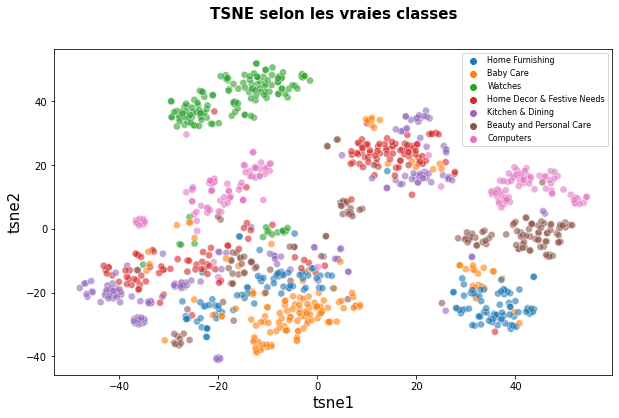

In [82]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters

#### 1) Création de clusters à partir du T-SNE :

In [83]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon cluster et calcul ARI de similarité :

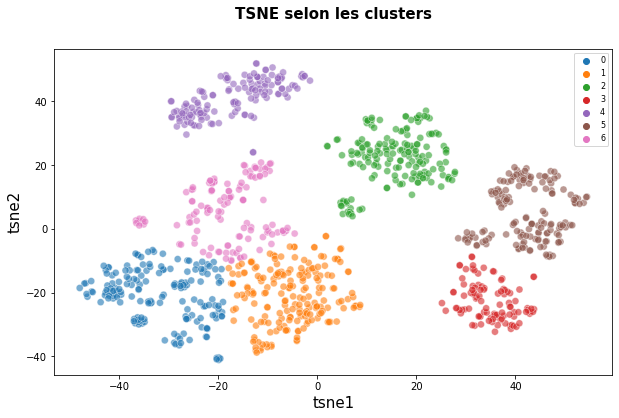

ARI :  0.3567093759872541


In [84]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.31595636837631336

#### 3) Analyse par classes :

In [85]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    172
1    197
2    168
3    100
4    138
5    150
6    125
Name: class, dtype: int64

In [86]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [87]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[102   0   6  14  20   8   0]
 [ 25  81   9  21   1  13   0]
 [  1  67  75   2   0   2   3]
 [  6   0  12  80   1  50   1]
 [ 45   0   4   1  75  25   0]
 [ 18   2   4  50   3  73   0]
 [  0   0  15   0   0   1 134]]

              precision    recall  f1-score   support

           0       0.52      0.68      0.59       150
           1       0.54      0.54      0.54       150
           2       0.60      0.50      0.55       150
           3       0.48      0.53      0.50       150
           4       0.75      0.50      0.60       150
           5       0.42      0.49      0.45       150
           6       0.97      0.89      0.93       150

    accuracy                           0.59      1050
   macro avg       0.61      0.59      0.59      1050
weighted avg       0.61      0.59      0.59      1050



<AxesSubplot:>

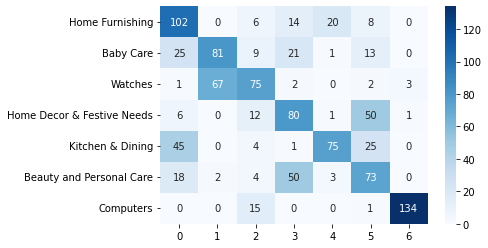

In [88]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [89]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [90]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## VIII - USE - UNIVERSAL SENTENCE ENCODER :

### A - Création du modèle Universal Sentence Encoder :

#### 1) Récupération du modèle :

In [91]:
# Récupération du modèle :
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#### 2) Entraînement du modèle :

In [92]:
# Paramètres et entraînement du modèle :
batch_size = 10
features_USE = nlp.feature_USE_fct(descriptions, batch_size, embed)

### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension T-SNE :

In [93]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(features_USE)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 2) Visualisation :

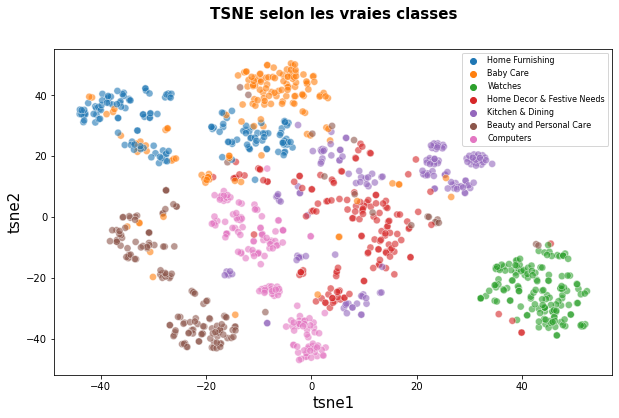

In [94]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters

#### 1) Création de clusters à partir du T-SNE :

In [95]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des descriptions selon clusters et calcul ARI de similarité :

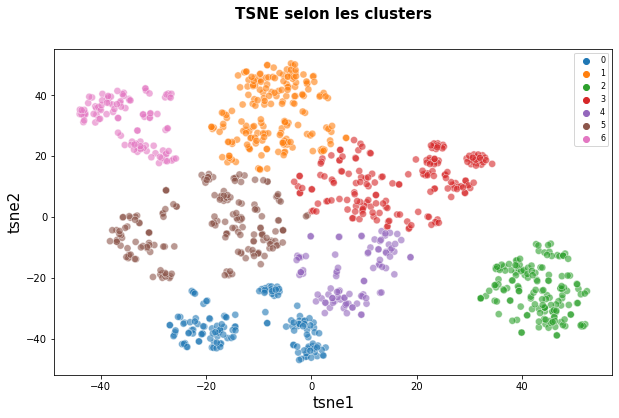

ARI :  0.438070300414467


In [96]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Note : le score ARI sans preprocessing du corpus est 0.43101083877137836

#### 3) Analyses par classes :

In [97]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    141
1    189
2    157
3    185
4     93
5    180
6    105
Name: class, dtype: int64

In [98]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [99]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[105   1  16   3  19   6   0]
 [  5  72  60   0   0  11   2]
 [  1  66  80   3   0   0   0]
 [  4   0  11  62   0  68   5]
 [ 63   0   1   0  86   0   0]
 [ 11   2  12  25   0 100   0]
 [  0   0   0   0   0   0 150]]

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       150
           1       0.51      0.48      0.49       150
           2       0.44      0.53      0.48       150
           3       0.67      0.41      0.51       150
           4       0.82      0.57      0.67       150
           5       0.54      0.67      0.60       150
           6       0.96      1.00      0.98       150

    accuracy                           0.62      1050
   macro avg       0.64      0.62      0.62      1050
weighted avg       0.64      0.62      0.62      1050



<AxesSubplot:>

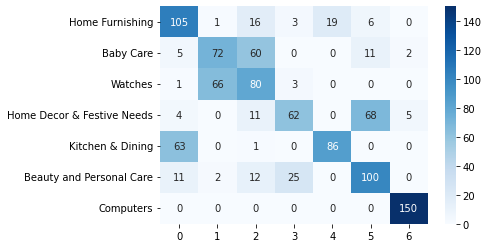

In [100]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [101]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [102]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

# PARTIE 2 : DONNÉES VISUELLES

## I - PREPROCESSING :

### A - Importation des fichiers :

In [23]:
# Importation des photos :
path = "C:/Users/7700k/Desktop/Openclassrooms/Classifiez_automatiquement_des_biens_de_consommation/dataset/Images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


### B - Ajout des images au dataframe principal :

In [24]:
# Jointure des images au dataframe principal :
data = data.sort_values(by="uniq_id")
data["image"] = list_photos

In [25]:
# Vérification :
data[data["uniq_id"] != data["image"].str.split(".").str[0]]

Empty DataFrame
Columns: [uniq_id, product_name, product_category_tree, description, brand, category_1, category_2, label, description_prepro, image]
Index: []

In [26]:
# Réindexation :
data = data.sort_index()

### C - Aperçu des catégories :

Home Furnishing


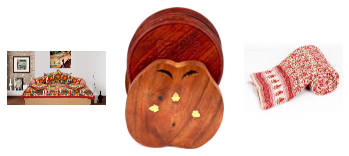

Baby Care


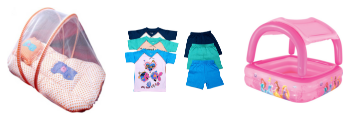

Watches


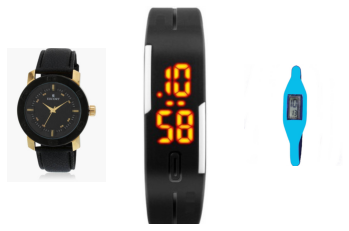

Home Decor & Festive Needs


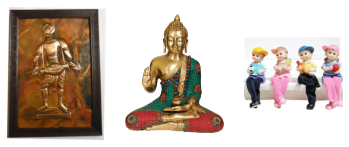

Kitchen & Dining


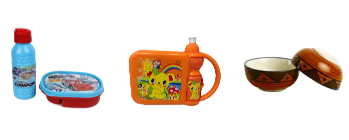

Beauty and Personal Care


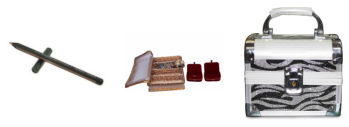

Computers


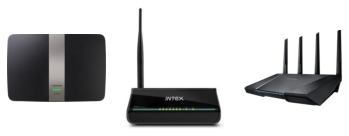

In [107]:
def list_fct(name) :
    list_image_name = [data["image"][i] for i in range(len(data)) if data["category_1"][i]==name]
    return list_image_name

for name in data["category_1"].unique() :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + "/" + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

## II - SIFT :

### A - Détermination et affichage des descripteurs SIFT (essai sur une image) :

#### 1) Définition du modèle SIFT :

In [108]:
# SIFT :
sift = cv2.xfeatures2d.SIFT_create()

#### 2) Conversion en gris :

In [34]:
# Conversion en gris :
image = cv2.imread(path + "/" + data["image"][10],0)

#### 3) Équalisation de l'histogramme :

In [36]:
# Égalisation :
image = cv2.equalizeHist(image)

#### 4) Détermination des descripteurs :

In [111]:
# Détermination des descripteurs :
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image,kp,image, (0, 255, 0), 
                        flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

#### 5) Affichage :

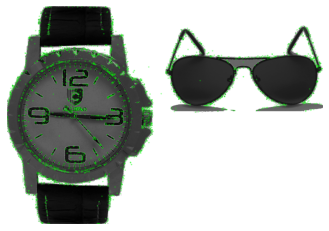

Descripteurs :  (2948, 128)

[[43. 16.  3. ...  0.  1.  9.]
 [45.  3.  0. ...  2.  9.  4.]
 [45. 15.  1. ...  0.  0. 10.]
 ...
 [ 5. 13. 22. ... 26.  6.  5.]
 [12. 26.  6. ... 14. 22. 19.]
 [52. 17. 13. ...  0.  0.  3.]]


In [112]:
# Affichage :
plt.imshow(img)
plt.axis("off")
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

### B - Pré-traitement des images via SIFT :

#### 1) Créations des descripteurs de chaque image :

* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [113]:
# Identification des key points et des descripteurs associés :
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(data["image"])) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path + "/" + data["image"][image_num] ,0)
    res = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           314.93 secondes


#### 2) Création des clusters de descripteurs :

In [114]:
# Détermination du nombre de clusters :

# k=70
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :           323.76 secondes


#### 3) Création des features des images :

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [115]:
# Création des histogrammes (features) :
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Création des matrices d'histogrammes :
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             4.01 secondes


### C - Réduction de dimension et visualisation :

#### 1) Réduction de dimension PCA :

* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [116]:
# PCA :
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


#### 2) Réduction de dimension T-SNE :

In [117]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 3) Visualisation :

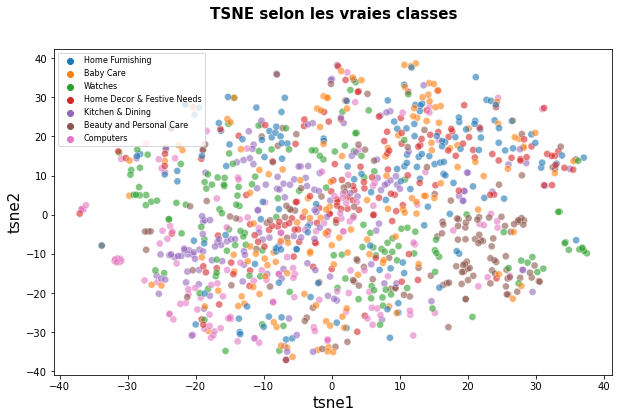

In [118]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### D) Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [119]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des images selon clusters et calcul ARI de similarité images / clusters :

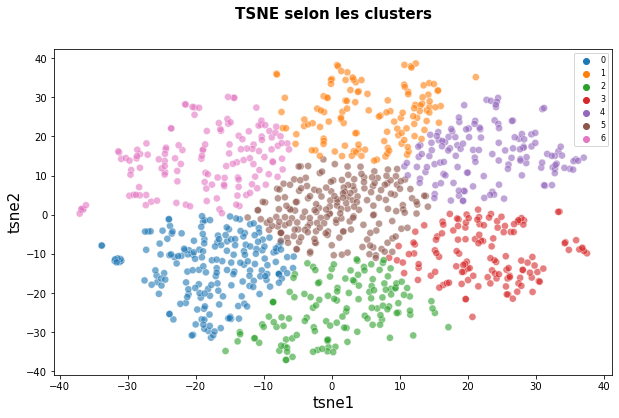

ARI :  0.06507890204322743


In [120]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

data.sort_values(by="image")
labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

#### 3) Analyse par classes :

In [121]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    193
1    123
2    132
3    131
4    135
5    200
6    136
Name: class, dtype: int64

In [122]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [123]:
# Choix manuel pour l'ordre de la matrice :
np.argmax(conf_mat, axis=0)

array([2, 0, 2, 1, 4, 3, 6], dtype=int64)

In [124]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [2,0,5,1,4,3,6]
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[32  6 24 31 21 22 14]
 [11 71 11 16 10 20 11]
 [ 6 11 54 26  4 31 18]
 [23  3 17 50 40  6 11]
 [19  8 14 18 46 18 27]
 [16  3 50 37 13 17 14]
 [16 29 23 22  1 18 41]]

              precision    recall  f1-score   support

           0       0.26      0.21      0.23       150
           1       0.54      0.47      0.51       150
           2       0.28      0.36      0.31       150
           3       0.25      0.33      0.29       150
           4       0.34      0.31      0.32       150
           5       0.13      0.11      0.12       150
           6       0.30      0.27      0.29       150

    accuracy                           0.30      1050
   macro avg       0.30      0.30      0.30      1050
weighted avg       0.30      0.30      0.30      1050



<AxesSubplot:>

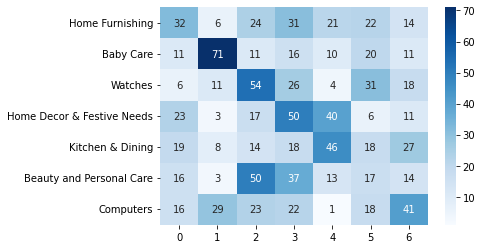

In [125]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [126]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [127]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()

## III - CNN IMAGE TRANSFER LEARNING (VGG16) :

### A - Transfert de modèle et calcul des features :

#### 1) Importation du modèle (VGG16) :

In [128]:
# Importation du modèle
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

#### 2) Préparation des images et récupérations des features :

In [129]:
# Préparation des images et récupérations des features :
VGG16_features = []
for image_num in range(len(data["image"])) :
    if image_num%100 == 0 : print(image_num)
    image = load_img(path + "/" + data["image"][image_num], target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image).reshape(-1)
    VGG16_features.append(feature)

0
1/1 [==============================] - 0s 125ms/step
100
1/1 [==============================] - 0s 127ms/step
200
1/1 [==============================] - 0s 128ms/step
300
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 129ms/step
400
1/1 [==============================] - 0s 127ms/step
500
1/1 [==============================] - 0s 125ms/step
600
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 126ms/step
700
1/1 [==============================] - 0s 127ms/step
800
1/1 [==============================] - 0s 130ms/step
900
1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 130ms/step
1000
1/1 [==============================] - 0s 126ms/step


### B - Réduction de dimension et visualisation :

#### 1) Réduction de dimension PCA :

In [130]:
# PCA :
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(VGG16_features)

#### 2) Réduction de dimension T-SNE :

In [131]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=50, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


#### 3) Visualisation :

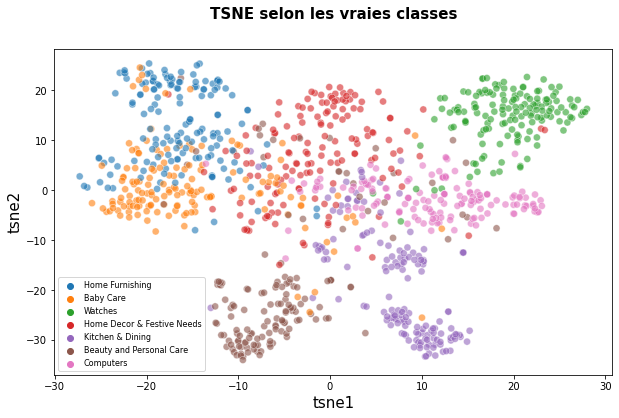

In [132]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

### C - Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [133]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des images selon clusters et calcul ARI de similarité :

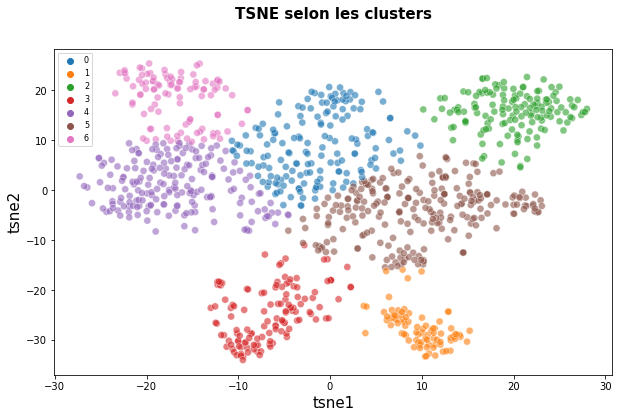

ARI :  0.5175231866427293


In [134]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

data.sort_values(by="image")
labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

#### 3) Analyse par classes :

In [135]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    163
1     84
2    143
3    129
4    191
5    237
6    103
Name: class, dtype: int64

In [136]:
# Création d'une matrice de confusion :
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

In [137]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[112   3   8  17   9   1   0]
 [  4 117  13  13   1   1   1]
 [  1   1 135  12   0   0   1]
 [ 21   2  14 109   1   0   3]
 [ 53   0   2   3  92   0   0]
 [  0   6  54   8   0  82   0]
 [  0   0  11   1   0   0 138]]

              precision    recall  f1-score   support

           0       0.59      0.75      0.66       150
           1       0.91      0.78      0.84       150
           2       0.57      0.90      0.70       150
           3       0.67      0.73      0.70       150
           4       0.89      0.61      0.73       150
           5       0.98      0.55      0.70       150
           6       0.97      0.92      0.94       150

    accuracy                           0.75      1050
   macro avg       0.80      0.75      0.75      1050
weighted avg       0.80      0.75      0.75      1050



<AxesSubplot:>

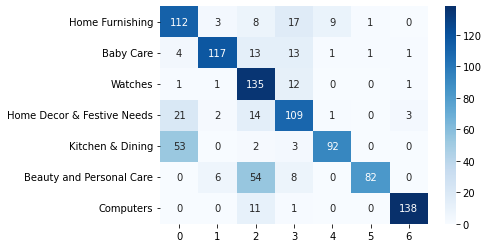

In [138]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [139]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [140]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()


# PARTIE 3 : ENSEMBLE TEXTES + IMAGES (ESSAI)

### A - Concaténation des features :

#### 1) Récupération des features :

In [141]:
# Récupération des features :
texts_features = pd.DataFrame(embeddings)
images_features = pd.DataFrame(VGG16_features)

#### 2) Concaténation des features :

In [142]:
# Concaténation des features :
ensemble_features = pd.concat([texts_features, images_features], axis=1)

### B - Réduction de dimension et concaténation :

#### 1) Réduction de dimension TSNE :

In [143]:
# Réduction de dimension :
tsne = manifold.TSNE(n_components=2, perplexity=50, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(ensemble_features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category_1"]
print(df_tsne.shape)

(1050, 3)


### C - Analyse mesures : similarité entre catégories et clusters :

#### 1) Création de clusters à partir du T-SNE :

In [144]:
# Clustering :
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2) Affichage des images selon clusters et calcul ARI de similarité :

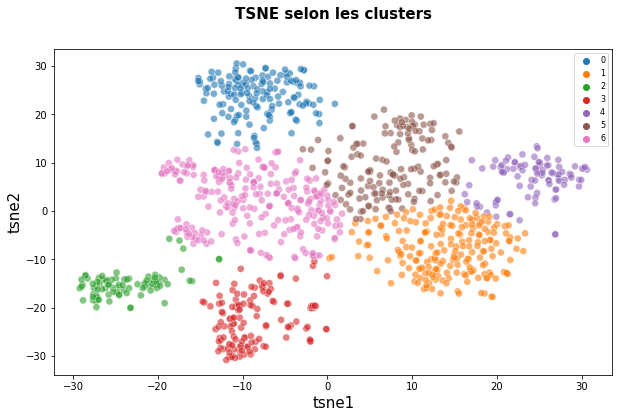

ARI :  0.5455543005999416


In [145]:
# Visualisation :
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 30, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 8}) 

plt.show()

data.sort_values(by="image")
labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

#### 3) Analyse par classes :

In [146]:
# Groupement des photos par clusters :
df_tsne.groupby("cluster").count()["class"]

cluster
0    147
1    206
2     85
3    128
4     92
5    150
6    242
Name: class, dtype: int64

In [147]:
# Affichage de la matrice de confusion et des scores :
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

[[116   4   6  14   9   1   0]
 [  7 117  13   9   1   1   2]
 [  2   0 143   2   0   2   1]
 [ 14   2  12 118   1   0   3]
 [ 65   0   2   2  81   0   0]
 [  2   5  57   5   0  81   0]
 [  0   0   9   0   0   0 141]]

              precision    recall  f1-score   support

           0       0.56      0.77      0.65       150
           1       0.91      0.78      0.84       150
           2       0.59      0.95      0.73       150
           3       0.79      0.79      0.79       150
           4       0.88      0.54      0.67       150
           5       0.95      0.54      0.69       150
           6       0.96      0.94      0.95       150

    accuracy                           0.76      1050
   macro avg       0.81      0.76      0.76      1050
weighted avg       0.81      0.76      0.76      1050



<AxesSubplot:>

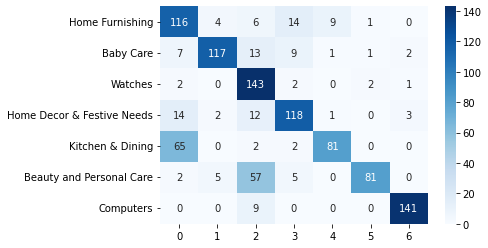

In [148]:
# Heatmap :
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["category_1"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 4) Diagramme de Sankey :

In [149]:
# Concaténation des tableaux de mouvements :
sankey_1 = pd.DataFrame(labels)
sankey_2 = pd.DataFrame(cls_labels_transform)
sankey = pd.concat([sankey_1, sankey_2], axis=1)
sankey["value"] = 1
sankey = sankey.groupby(["label", "y_pred_transform"]).count().reset_index()
sankey["y_pred_transform"] = sankey["y_pred_transform"]+7

In [150]:
# Diagramme de Sankey :
fig = go.Figure(data=[go.Sankey(

    node = dict(
        pad = 10,
        thickness = 75,
        line = dict(color = "black", width = 0.5),
        label = ["Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers",
                 "Home Furnishing", "Baby Care", "Watches", "Decor & Festive Needs", "Kitchen & Dining", "Beauty", "Computers"],
        color = ["steelblue","firebrick","purple","darkseagreen","blue","orange", "gold",
                 "steelblue","firebrick","purple","darkseagreen","blue","orange", "gold"]),

    link = dict(source = sankey["label"], 
                target = sankey["y_pred_transform"],
                value = sankey["value"]))])

fig.update_layout(title_text="diagramme de Sankey", font_size=10)
fig.show()